In [129]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import json
from datetime import datetime
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

from langdetect import detect

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_codeToText = pd.read_csv('data_gp/codeToText.tsv', sep='\t', on_bad_lines='skip', header = None)
df_journal = pd.read_csv('data_gp/journals_shot.tsv', sep='\t', on_bad_lines='skip')

In [27]:
df_journal.shape, df_codeToText.shape

((60000, 6), (145, 2))

In [39]:
df_journal.head(5)

,id,userId,eventTime,eventCode,content,additional
0,b25c7564-b084-42ef-90f7-ce8466b4560e,cf943c19-a2df-447b-9d26-77727d7c555b,2019-08-09 17:31:01.298,SignedInEvent,NaN,"{""utmParams"": null}"
1,17f45c55-2a8c-4b05-8d6f-651899a928cf,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:31:08.639,ObjectViewedJournalEvent,"{""content"": {""identifier"": ""67fe6e4e-1e8c-4ab0...","{""utmParams"": null}"
2,b1e69af1-4c4e-4208-bf6c-8dc03ae6eb9b,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:31:17.066,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 0, ""query""...","{""utmParams"": null}"
3,5382f088-cf0c-419e-a14e-0466aa0452e2,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:59:51.295,SignedOutEvent,NaN,"{""utmParams"": null}"
4,32dbe698-8d51-4148-9017-5137e75bac23,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:59:51.948,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 0, ""query""...","{""utmParams"": null}"


In [29]:
df_codeToText.head(5)

,0,1
0,SearchExecutedJournalEvent,Выполнен поиск
1,ObjectViewedJournalEvent,Просмотрен объект
2,SearchQueryExpandedEvent,Выполнено расширение запроса
3,TrainingMaterialAddedEvent,Добавлен обучающий материал
4,TrainingMaterialStatsChangedEvent,Изменён статус обучающего материала


In [3]:
df_merge = df_journal.merge(df_codeToText, left_on='eventCode', right_on=0, how='left', sort=False)
df_merge = df_merge.drop(columns=[0])
df_merge = df_merge.rename(columns={1: 'eventCodeReadable'})
df_merge.head(5)

,id,userId,eventTime,eventCode,content,additional,eventCodeReadable
0,b25c7564-b084-42ef-90f7-ce8466b4560e,cf943c19-a2df-447b-9d26-77727d7c555b,2019-08-09 17:31:01.298,SignedInEvent,NaN,"{""utmParams"": null}",Пользователь зашел в систему
1,17f45c55-2a8c-4b05-8d6f-651899a928cf,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:31:08.639,ObjectViewedJournalEvent,"{""content"": {""identifier"": ""67fe6e4e-1e8c-4ab0...","{""utmParams"": null}",Просмотрен объект
2,b1e69af1-4c4e-4208-bf6c-8dc03ae6eb9b,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:31:17.066,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 0, ""query""...","{""utmParams"": null}",Выполнен поиск
3,5382f088-cf0c-419e-a14e-0466aa0452e2,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:59:51.295,SignedOutEvent,NaN,"{""utmParams"": null}",Пользователь вышел из системы
4,32dbe698-8d51-4148-9017-5137e75bac23,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:59:51.948,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 0, ""query""...","{""utmParams"": null}",Выполнен поиск


In [4]:
df_merge['eventCodeReadable'].value_counts()

Выполнен поиск                                   33184
Пользователь перенаправлен с внешнего ресурса     9629
Пользователь активен                              8188
Просмотрен объект                                 7112
Просмотрен список справочников                     564
Просмотрен список пользователей                    524
Выполнено расширение запроса                       283
Просмотрен справочник                              158
Просмотрен список закладок                          74
Изменён элемент справочника                         34
Документ добавлен в закладки                        33
Обратная связь                                      30
Просмотрен список организаций                       28
Пользователь зашел в систему                        24
Изменён список ролей пользователя                   21
Пользователь вышел из системы                       19
Неудачный вход в систему                            17
Сообщение об ошибке                                 15
Выполнена 

In [5]:
df_merge['eventCode'].value_counts()

SearchExecutedJournalEvent       33184
RedirectedFromExternalWithUtm     9629
UserStartActivity                 8188
ObjectViewedJournalEvent          7112
CatalogListViewedEvent             564
ProfileListViewedEvent             524
SearchQueryExpandedEvent           283
CatalogViewedEvent                 158
BookmarksViewedEvent                74
CatalogItemUpdatedEvent             34
BookmarkAddedEvent                  33
FeedbackSent                        30
OrganizationListViewedEvent         28
SignedInEvent                       24
UserRoleAssignation                 21
SignedOutEvent                      19
SignInFailed                        17
ErrorFound                          15
JournalDownloaded                   14
CatalogItemCreatedEvent             13
BookmarkRemovedEvent                11
RoleMappingRulesUpdated             11
CatalogDeletedEvent                  7
UserStateChangedEvent                4
CatalogItemDeletedEvent              3
Name: eventCode, dtype: i

In [6]:
len(df_merge['eventCodeReadable'].value_counts())

25

In [7]:
# Проверили, что нет незаполненных строк со значениями null - это означало бы что некоторые коды отсутствуют в df_codeToText
# Также выяснилось, что использовалось только 25 кодов из 145

In [8]:
# 1) сколько всего пользователей?
len(df_merge['userId'].value_counts())

2261

In [9]:
# 2) в какое время суток заходят?

# мы хотим создать новые фичи из существующих, для данной задачи можно использовать часы
# время суток условно можно разделить на 4е части: утро (06-12), день (12-18), вечер (18-24), ночь (24-06)
# опять же это все условно, часы можно двигать в любую сторону

# другой вопрос, что в колонке eventCode означает "пользователь заходит"? 
# Пользователь зашел в систему (24 события) - SignedInEvent 
# Пользователь перенаправлен с внешнего ресурса (9629 события) - RedirectedFromExternalWithUtm
# как видно, пользователи в основном заходят в нашу систему только с внешних ресурсов

# 2019-08-09 17:59:51.948
def getTimeOfDay(hour):
    if 12 > hour > 5:
        return 'morning'
    if 18 > hour > 11:
        return 'day'
    if 24 > hour > 17:
        return 'evening'
    return 'night'

def getHour(x):
    return int(x.split(' ')[1].split(':')[0].strip())

def getYear(x):
    return int(x.split(' ')[0].split('-')[0].strip())

def getMonth(x):
    return int(x.split(' ')[0].split('-')[1].strip())

def getWeek(x):
#     datetime_object = datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S')
    week_number = datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S').isocalendar()[1]
    return week_number

df_merge['hour'] = df_merge['eventTime'].apply(getHour)
df_merge['year'] = df_merge['eventTime'].apply(getYear)
df_merge['month'] = df_merge['eventTime'].apply(getMonth)
df_merge['week'] = df_merge['eventTime'].apply(getWeek)
df_merge['TimeOfDay'] = df_merge['hour'].apply(getTimeOfDay)
df_merge.head(10)

,id,userId,eventTime,eventCode,content,additional,eventCodeReadable,hour,year,month,week,TimeOfDay
0,b25c7564-b084-42ef-90f7-ce8466b4560e,cf943c19-a2df-447b-9d26-77727d7c555b,2019-08-09 17:31:01.298,SignedInEvent,NaN,"{""utmParams"": null}",Пользователь зашел в систему,17,2019,8,32,day
1,17f45c55-2a8c-4b05-8d6f-651899a928cf,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:31:08.639,ObjectViewedJournalEvent,"{""content"": {""identifier"": ""67fe6e4e-1e8c-4ab0...","{""utmParams"": null}",Просмотрен объект,17,2019,8,32,day
2,b1e69af1-4c4e-4208-bf6c-8dc03ae6eb9b,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:31:17.066,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 0, ""query""...","{""utmParams"": null}",Выполнен поиск,17,2019,8,32,day
3,5382f088-cf0c-419e-a14e-0466aa0452e2,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:59:51.295,SignedOutEvent,NaN,"{""utmParams"": null}",Пользователь вышел из системы,17,2019,8,32,day
4,32dbe698-8d51-4148-9017-5137e75bac23,ca036cd8-dc22-4377-9fa4-fe073313e464,2019-08-09 17:59:51.948,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 0, ""query""...","{""utmParams"": null}",Выполнен поиск,17,2019,8,32,day
5,d3a8d5d4-fedf-4b4a-a5a2-b173b3911087,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:00:03.21,SignedInEvent,NaN,"{""utmParams"": null}",Пользователь зашел в систему,18,2019,8,32,evening
6,8c04d63a-a758-4b04-a42d-4263513cf147,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:00:06.829,CatalogListViewedEvent,NaN,"{""utmParams"": null}",Просмотрен список справочников,18,2019,8,32,evening
7,e35c5699-48a8-43d4-9752-fd2a18c4a618,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:00:31.421,CatalogListViewedEvent,NaN,"{""utmParams"": null}",Просмотрен список справочников,18,2019,8,32,evening
8,946e28b3-df48-48e2-82ef-c86ba87275ff,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:01:41.405,CatalogListViewedEvent,NaN,"{""utmParams"": null}",Просмотрен список справочников,18,2019,8,32,evening
9,c5a76389-71a7-4d02-973a-c3055f7d42df,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:02:28.481,CatalogListViewedEvent,NaN,"{""utmParams"": null}",Просмотрен список справочников,18,2019,8,32,evening


In [10]:
# 9629 + 24 = 9653
df_sign_in = df_merge[(df_merge['eventCode'] == 'SignedInEvent') | (df_merge['eventCode'] == 'RedirectedFromExternalWithUtm')]
df_sign_in.shape

(9653, 12)

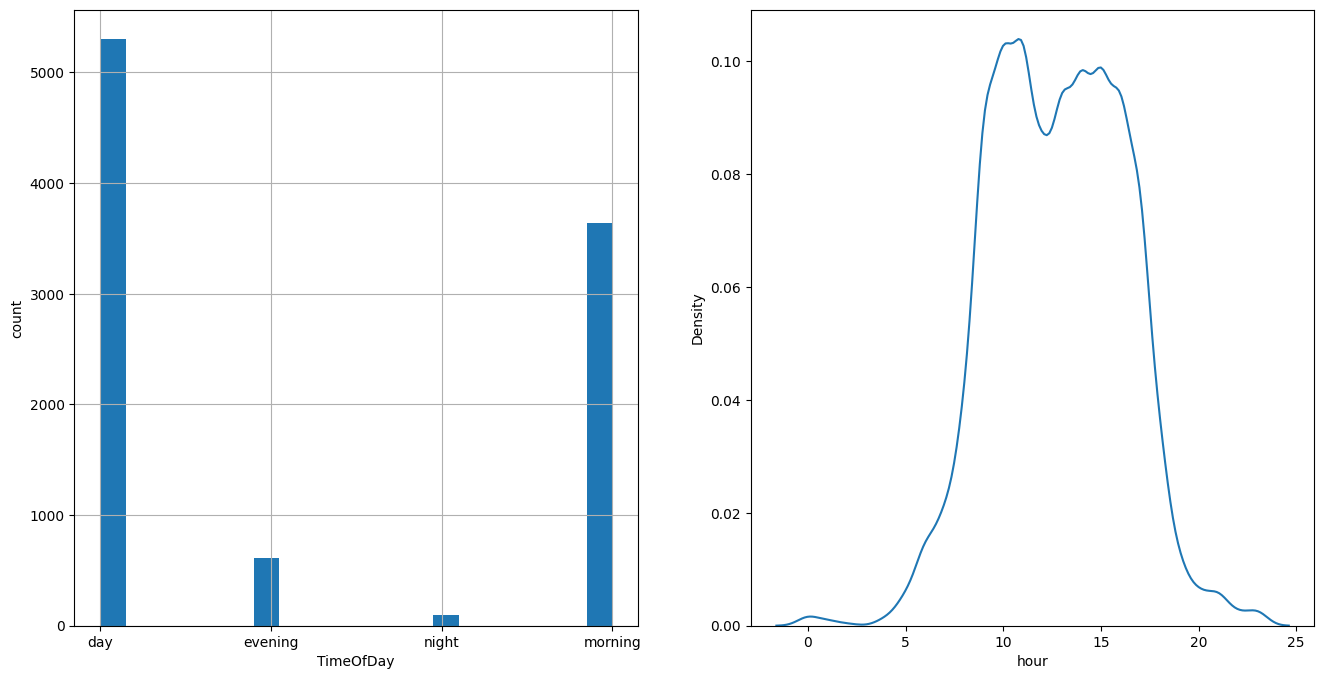

In [11]:
plt.figure(figsize=(16,8))

plt.subplot(121)
df_sign_in['TimeOfDay'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('TimeOfDay')

plt.subplot(122)
sns.kdeplot(df_sign_in['hour'], legend=False)
plt.xlabel('hour')

plt.show()

In [12]:
# как видно из гистограммы и графика плотности вероятности по времени, 
# пользователи обычно заходят утром и днем в период времени примерно с 8:00 утра до 19:00 вечера

In [13]:
# 3) сколько новых и старых пользователей заходит?

# для ответа на этот вопрос неплохо понять, что означает новый и старый пользователь. 
# по журналу событий не нашел самого очевидного решения - это регистрация пользователя
# поэтому нужно что-то придумать. Хочется посмотреть на год и месяц первого входа

In [14]:
df_merge['year'].value_counts()

2019    60000
Name: year, dtype: int64

In [15]:
df_merge['month'].value_counts()

10    19319
8     15837
9     13689
11    11155
Name: month, dtype: int64

In [16]:
df_sign_in['month'].value_counts()

10    3049
9     2679
8     1981
11    1944
Name: month, dtype: int64

In [17]:
# ожидал немного большего разброса по годам. В целом все условности относительный.
# Пусть старые пользователи - это те, кто первый раз зашел в 8ом месяце
# Новые - только в 11
# новых посчитать чуть легче, просто срезаем выборку по 11му месяцу

In [18]:
# в выборке присутствуют NaN 'userId'
df_old = df_sign_in[df_sign_in['month'] == 8]
df_month_9 = df_sign_in[df_sign_in['month'] == 9]
df_month_10 = df_sign_in[df_sign_in['month'] == 10]
df_last_month = df_sign_in[df_sign_in['month'] == 11]


df_old = df_old.dropna(subset=['userId'])
df_month_9 = df_month_9.dropna(subset=['userId'])
df_month_10 = df_month_10.dropna(subset=['userId'])
df_last_month = df_last_month.dropna(subset=['userId'])


old_user_id = df_old['userId'].unique()
month_9_user_id = df_month_9['userId'].unique()
month_10_user_id = df_month_10['userId'].unique()
last_month_user_id = df_last_month['userId'].unique()

In [19]:
len(old_user_id), len(month_9_user_id), len(month_10_user_id), len(last_month_user_id)

(593, 762, 775, 584)

In [20]:
c = list(set(old_user_id) & set(last_month_user_id))
len(c), len(old_user_id)

(126, 593)

In [21]:
# 126 из 593 пользователей, которые первый раз посетили сервис в первый месяц пользуются им до сих пор

In [22]:
# у нас список пользователей по каждому месяцу
new_in_8_month = list(set(old_user_id))
new_in_9_month = list(set(month_9_user_id) - set(new_in_8_month))
new_in_10_month = list(set(month_10_user_id) - set(new_in_8_month) - set(new_in_9_month))
new_in_11_month = list(set(last_month_user_id) - set(new_in_8_month) - set(new_in_9_month) - set(new_in_10_month))

len(set(new_in_8_month)), len(set(new_in_9_month)), len(set(new_in_10_month)), len(new_in_11_month)

(593, 572, 476, 297)

In [23]:
# в последний месяц у нас 297 новых пользователей, которые ни разу не входили в систему в предыдущие месяца

In [24]:
593+572+476+297, len(df_merge['userId'].value_counts())

(1938, 2261)

In [25]:
# почему не сходится с числом уникальных пользователей? потому что выборка взята по пользователям, которые входили в систему.
# это означает либо есть еще action действие, которое означает вход, либо просто нет для оставшихся уникальных пользователей
# события, которое означало бы вход для них (как буд-то они сразу считаются вошедшими)

In [ ]:
# 4) сколько действий совершают пользователи?

# считаем что каждый eventCode - это действие
# можно просто разделить общее число действий (60к) на число уникальных пользователей
# так мы узнаем среднее число действие для пользователей

In [170]:
len(df_merge) / len(df_merge['userId'].unique()), len(df_merge)

(26.536930561698362, 26.52519893899204, 60000)

In [ ]:
# но, возможно, вы тут что-то другое имели ввиду

In [26]:
actions_11 = df_merge[df_merge['userId'].isin(new_in_11_month)]
actions_10 = df_merge[df_merge['userId'].isin(new_in_10_month)]
actions_9 = df_merge[df_merge['userId'].isin(new_in_9_month)]
actions_8 = df_merge[df_merge['userId'].isin(new_in_8_month)]

In [27]:
actions_11.shape, actions_10.shape, 

((3087, 12), (8877, 12))

In [28]:
len(actions_11) / len(actions_11['userId'].unique()), len(actions_10) / len(actions_10['userId'].unique())

(10.393939393939394, 18.649159663865547)

In [29]:
len(actions_9) / len(actions_9['userId'].unique()), len(actions_8) / len(actions_8['userId'].unique())

(20.617132867132867, 49.010118043844855)

In [30]:
# можно заметить, что чем старее (не по возрасту) пользователь, тем в среднем больше он совершает действий

In [31]:
# число действий для каждого пользователя
grouped = df_merge.groupby(['userId'])

for i, (name, group) in enumerate(grouped):
    print(f'{i}: {len(group)}')
    i += 1

0: 38
1: 96
2: 3
3: 5
4: 47
5: 61
6: 31
7: 7
8: 4
9: 4
10: 47
11: 7
12: 106
13: 53
14: 7
15: 5
16: 8
17: 57
18: 4
19: 106
20: 4
21: 4
22: 10
23: 2
24: 16
25: 10
26: 50
27: 9
28: 8
29: 14
30: 3
31: 6
32: 21
33: 45
34: 4
35: 6
36: 20
37: 6
38: 48
39: 4
40: 243
41: 6
42: 9
43: 16
44: 4
45: 39
46: 15
47: 4
48: 7
49: 32
50: 9
51: 14
52: 50
53: 4
54: 7
55: 2
56: 53
57: 4
58: 6
59: 11
60: 5
61: 6
62: 20
63: 33
64: 7
65: 10
66: 4
67: 4
68: 14
69: 7
70: 5
71: 4
72: 2
73: 14
74: 4
75: 6
76: 2
77: 5
78: 29
79: 4
80: 27
81: 5
82: 4
83: 5
84: 24
85: 48
86: 3
87: 9
88: 4
89: 27
90: 154
91: 17
92: 4
93: 37
94: 34
95: 39
96: 4
97: 15
98: 7
99: 4
100: 4
101: 4
102: 5
103: 16
104: 16
105: 27
106: 13
107: 2
108: 5
109: 4
110: 72
111: 4
112: 2
113: 4
114: 3
115: 11
116: 2
117: 2
118: 8
119: 17
120: 7
121: 70
122: 4
123: 4
124: 5
125: 7
126: 8
127: 5
128: 4
129: 5
130: 4
131: 8
132: 5
133: 4
134: 230
135: 5
136: 207
137: 4
138: 2
139: 29
140: 23
141: 9
142: 6
143: 4
144: 11
145: 15
146: 5
147: 5
148: 7
149

In [ ]:
# 5) сколько пользователей пользуются регулярно (минимум пару раз за неделю)?

In [32]:
# мы создали фичу week, которая означет номер недели. Всего у нас 4 месяца т.е. 16 недель
# по сути просто перебираем уникальных пользователей, группируем их по неделям и смотрим чтобы в каждой неделе было больше 2х действий

grouped = df_merge.groupby(['userId'])
for name, group in grouped:
    inner_grouped = group.groupby(['week'])
    if len(inner_grouped) == 16:
        print(name, len(inner_grouped))
        for inner_name, inner_group in inner_grouped:
            if len(inner_group) > 1:
                continue
            print('not active user, 1 time in week')
        else:
            print('active user, > 1 times in week')

ba94f118-6e50-4fb1-98e3-6ad795e19abb 16
active user, > 1 times in week
ca036cd8-dc22-4377-9fa4-fe073313e464 16
active user, > 1 times in week


In [ ]:
# 6) что ищут пользователи?
# провести группировку запросов, выделить похожие или однотипные запросы

In [33]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [138]:
df_merge_2 = df_merge.copy()
df_search = df_merge_2[df_merge_2['eventCode'] == 'SearchExecutedJournalEvent']
df_search['query'] = ''
df_search['query_is_name'] = 0
df_search['query_is_date'] = 0
df_search['query_is_language'] = 0
df_search['query_is_mail'] = 0
df_search['query_is_link'] = 0
df_search['query_is_hash_tag'] = 0


queries = []
for index, row in df_search.iterrows():
    names_list = []
    json_object = json.loads(row['content'])
    if json_object['docRequest']['query'] != '':
        query = json_object['docRequest']['query'].lower().strip()
        queries.append(query)
        
        matches = dates_extractor(query)
        facts = [i.fact.as_json for i in matches]
        if len(facts) > 0:
            df_search.at[index, 'query_is_date'] = 1
        
        try:
            df_search.at[index, 'query_is_language'] = detect(query)
        except:
            pass
        
        if query.find("@") != -1:
            df_search.at[index, 'query_is_mail'] = 1
            
        if query.find("http") != -1:
            df_search.at[index, 'query_is_link'] = 1
            
        if query.find("#") != -1:
            df_search.at[index, 'query_is_hash_tag'] = 1
        
        
        matches = names_extractor(query)
        names = [i.fact.as_json for i in matches]
        if len(names) > 0:
            df_search.at[index, 'query_is_name'] = 1
        
        df_search.at[index, 'query'] = query


In [139]:
df_search[df_search['query'] != '']

,id,userId,eventTime,eventCode,content,additional,eventCodeReadable,hour,year,month,week,TimeOfDay,query,query_is_name,query_is_date,query_is_language,query_is_mail,query_is_link,query_is_hash_tag
40,5074a6aa-249a-44e0-82ca-f4eea3c80c8d,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:19:16.718,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,18,2019,8,32,evening,pfzdktybt,0,0,pl,0,0,0
48,d08741b4-2e2a-4553-bae2-0379fad3b968,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:31:58.474,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,18,2019,8,32,evening,дюков,1,0,uk,0,0,0
50,aa3699d5-16b5-4cd2-b7d9-fbd678ff3ac7,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:32:08.81,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,18,2019,8,32,evening,дюков,1,0,uk,0,0,0
58,47ee3bc2-1d40-4cfe-b405-5a5a2ff95718,3f99c8da-6921-4981-878b-0617e2670f85,2019-08-09 19:36:29.289,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,19,2019,8,32,evening,ищем,0,0,bg,0,0,0
59,f8b81366-6259-4d86-8fb0-f253903c1a86,3f99c8da-6921-4981-878b-0617e2670f85,2019-08-09 19:36:29.451,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,19,2019,8,32,evening,ляляя,0,0,ru,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59988,c8477f2c-ba7f-4d65-826f-57a439d65b04,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:48:09.881,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,ш-01.07.04.01-05,0,1,mk,0,0,0
59989,5ea7e1ff-bba5-428a-8a89-e58cb696ed55,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:48:47.875,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,акт допуска для производства работ,1,0,ru,0,0,0
59990,51bc0364-71bf-4d20-89c5-52a8c3df2f58,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:48:51.987,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,акт допуска для производства работ,1,0,ru,0,0,0
59991,a4e1fc07-0bee-4528-9264-384ff4308529,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:48:52.474,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,акт допуска для производства работ,1,0,ru,0,0,0


In [60]:
# что ищут пользователи?
# список уникальных запросов
queries = list(set(queries))
queries

['',
 'кт - 696',
 '15.02.04.01',
 'комаров а',
 'история',
 'порядок управления проектами',
 'должностной оклад',
 'объем премиальных продаж',
 'методика нормализации ebitda',
 'правила внутреннего трудового распорядка',
 'pfzd',
 'установка стендов безопасности в зонах установки общих принтеров',
 'налоговый вестник',
 'кофе',
 'внутренние коммуникации',
 'ск-08.02.05.02',
 'аналитическая справка затраты',
 'как настроить уведомления о рассылкe к каждой папке отдельно?',
 'alexander samsonov',
 'кукиева',
 'зимнее',
 'битум',
 'комитет потребителей',
 'м-15.03.04-03 интеграция информационных систем',
 'компетенции',
 'шурыгин',
 'клежно',
 'гпн-гео енисей',
 'ск-13.03.04',
 'hr оцо',
 'шевченоко александр',
 'методология каркас безопасности',
 'каталог владелцев данных бизнес систем',
 '54-п от 10.06.2019',
 'сладкий ноябрь',
 'демина александра дмитриевна',
 'заместитель управляющего',
 '•\tск-15.04.01 порядок предоставления доступа к информационным ресурсам и ит сервисам',
 'кт-001

In [61]:
# число уникальных запросов
len(queries)

7256

In [149]:
# как выидно библиотека natasha не всегда корректно справляется с датами (ш-01.07.05-20 - это выглядит как какая-то аббревеатура)
# что бы я сделал с большим количеством времени? 
# - изучил бы более детально данные, хочется разобраться с аббревеатурами
# - можно посмотреть другие библиотеки
# - также можно использовать rule-based подход
df_date = df_search[df_search['query_is_date'] == 1]
df_date

,id,userId,eventTime,eventCode,content,additional,eventCodeReadable,hour,year,month,week,TimeOfDay,query,query_is_name,query_is_date,query_is_language,query_is_mail,query_is_link,query_is_hash_tag
153,19b4164c-cbdd-4c11-b0b2-10578e451914,7aee4a7f-54c4-4f43-bc95-aa598253822d,2019-08-12 15:41:37.7,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,15,2019,8,33,day,"кт-311 перечень должностных лиц, имеющих право...",1,1,ru,0,0,0
155,75560c06-badc-40c2-aea0-8c9c69cc5107,7aee4a7f-54c4-4f43-bc95-aa598253822d,2019-08-12 15:41:49.647,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,15,2019,8,33,day,"кт-311 перечень должностных лиц, имеющих право...",1,1,ru,0,0,0
157,bd1c2547-1a0b-47e1-bbe3-5d47a59c3268,7aee4a7f-54c4-4f43-bc95-aa598253822d,2019-08-12 15:42:01.711,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,15,2019,8,33,day,"кт-311 перечень должностных лиц, имеющих право...",1,1,ru,0,0,0
1743,3e73c590-0658-4ee6-a593-746e84e8d9d2,4e75dc09-6fa8-4a40-9e22-a0dbfb846466,2019-08-15 07:38:22.983,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,8,33,morning,ш-01.07.05-20,0,1,mk,0,0,0
1745,13ab53a4-3c73-4391-ad1b-1fc5459d2f0a,4e75dc09-6fa8-4a40-9e22-a0dbfb846466,2019-08-15 07:38:31.527,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,8,33,morning,ш-01.07.05-20,0,1,mk,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59983,1a6b07d5-0f07-415f-a8f9-9b9581da043b,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:47:31.198,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,01.07.04.01-10,0,1,0,0,0,0
59984,f0a72ca0-9371-443b-82f7-dbc1c552e112,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:47:46.18,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,01.07.04.01-05,0,1,0,0,0,0
59985,ec951455-ec1f-4d7d-ab20-9eeeb4fe9d51,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:47:49.078,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,01.07.04.01-05,0,1,0,0,0,0
59986,c3878bc9-2bc6-4a4f-a87a-7d3da699cb37,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:47:50.791,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,01.07.04.01-05,0,1,0,0,0,0


In [ ]:
# для группировки аббревеатур думаю лучше просто использовать rule-based подход т.к. кажется, что в данных
# присутствуют специфические аббревеатуры

In [150]:
df_name = df_search[df_search['query_is_name'] == 1]
df_name

,id,userId,eventTime,eventCode,content,additional,eventCodeReadable,hour,year,month,week,TimeOfDay,query,query_is_name,query_is_date,query_is_language,query_is_mail,query_is_link,query_is_hash_tag
48,d08741b4-2e2a-4553-bae2-0379fad3b968,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:31:58.474,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,18,2019,8,32,evening,дюков,1,0,uk,0,0,0
50,aa3699d5-16b5-4cd2-b7d9-fbd678ff3ac7,7e2fbd0f-96cf-45f0-8430-2adee15176bb,2019-08-09 18:32:08.81,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,18,2019,8,32,evening,дюков,1,0,uk,0,0,0
112,dccdbbdc-fbad-472f-bf46-a1c4c4667796,324a8ff1-2509-440b-a16f-3e5f73050eca,2019-08-12 09:52:24.982,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,9,2019,8,33,morning,нефть,1,0,uk,0,0,0
131,484f325c-c95e-4fa2-b5b3-9feeffe37548,7aee4a7f-54c4-4f43-bc95-aa598253822d,2019-08-12 15:37:21.491,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,15,2019,8,33,day,нефть,1,0,uk,0,0,0
133,11c5b047-a40f-44b1-9aa1-a8f68fcba2d0,7aee4a7f-54c4-4f43-bc95-aa598253822d,2019-08-12 15:37:31.137,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,15,2019,8,33,day,нефть,1,0,uk,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59974,dba66e18-1762-491a-8d79-9e629dd0022c,fb025cb3-c832-43f2-b68b-e4056d779c40,2019-11-21 06:29:37.739,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,6,2019,11,47,morning,лига профессионалов,1,0,ru,0,0,0
59989,5ea7e1ff-bba5-428a-8a89-e58cb696ed55,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:48:47.875,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,акт допуска для производства работ,1,0,ru,0,0,0
59990,51bc0364-71bf-4d20-89c5-52a8c3df2f58,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:48:51.987,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,акт допуска для производства работ,1,0,ru,0,0,0
59991,a4e1fc07-0bee-4528-9264-384ff4308529,82690a24-6ec8-4970-8d53-2dcca25280d2,2019-11-21 07:48:52.474,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,7,2019,11,47,morning,акт допуска для производства работ,1,0,ru,0,0,0


In [ ]:
# для имен также можно использовать словари 

In [140]:
# для почты, ссылок и хэштегов лучше сделать поиск с помощью регулярных выражений
# здесь будут встречаться неточности
df_mail = df_search[df_search['query_is_mail'] == 1]
df_link = df_search[df_search['query_is_link'] == 1]
df_hash_tag = df_search[df_search['query_is_hash_tag'] == 1]

In [151]:
df_link

,id,userId,eventTime,eventCode,content,additional,eventCodeReadable,hour,year,month,week,TimeOfDay,query,query_is_name,query_is_date,query_is_language,query_is_mail,query_is_link,query_is_hash_tag
15580,026e388e-23e3-4aa4-9a09-06ef1aa6d757,487fd14c-36bd-44db-a3c6-3f35c502349a,2019-08-30 13:41:07.623,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,13,2019,8,35,day,"<a src=""https://im0-tub-ru.yandex.net/i?id=c09...",0,0,ca,0,1,0
15581,4fcf4a11-ff16-4752-a994-b733787c46ac,487fd14c-36bd-44db-a3c6-3f35c502349a,2019-08-30 13:41:23.279,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,13,2019,8,35,day,"<a src=""https://im0-tub-ru.yandex.net/i?id=c09...",0,0,ca,0,1,0
17081,6ef831b2-cdbe-4bc2-8f8c-6bf7be1a7437,f2b79c19-fe22-4b6f-81ae-eea77fd37169,2019-09-03 12:12:15.676,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,12,2019,9,36,day,https://mail.gazprom-neft.ru/owa/redir.aspx?c=...,0,0,0,0,1,0
17082,b6ec41c0-de71-4f7e-8aa4-1841c6d3c5ce,f2b79c19-fe22-4b6f-81ae-eea77fd37169,2019-09-03 12:15:29.749,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,12,2019,9,36,day,http://srz.gazprom-neft.local/communities/hse/...,0,0,0,0,1,0
17083,1c0c3f52-cf81-4bc0-9558-53ddd3d83992,f2b79c19-fe22-4b6f-81ae-eea77fd37169,2019-09-03 12:15:52.29,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 10, ""limit"": 10, ""quer...","{""utmParams"": null}",Выполнен поиск,12,2019,9,36,day,http://srz.gazprom-neft.local/communities/hse/...,0,0,0,0,1,0
17085,854e9255-7350-4eb9-a95c-4d2dda22622c,f2b79c19-fe22-4b6f-81ae-eea77fd37169,2019-09-03 12:16:32.234,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 20, ""limit"": 10, ""quer...","{""utmParams"": null}",Выполнен поиск,12,2019,9,36,day,http://srz.gazprom-neft.local/communities/hse/...,0,0,0,0,1,0
29848,0eaeece6-f11c-468a-920b-ceb6992e5e1d,0ca8b4da-ecc1-4837-b306-fccbc5be6360,2019-10-01 14:44:00.334,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,14,2019,10,40,day,http://10.50.18.235/wellpivot/index.html,0,0,0,0,1,0
31568,5e793a6a-59c3-48fa-a94f-8310ba0520a9,d4c42c8f-1b7e-48a1-b63c-93e5a4c74bf3,2019-10-04 12:53:19.627,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,12,2019,10,40,day,https://alm-itsk.gazprom-neft.local/tfs/datare...,0,0,0,0,1,0
31569,baf44996-a111-43a1-8097-1a736eafc1f8,d4c42c8f-1b7e-48a1-b63c-93e5a4c74bf3,2019-10-04 12:53:42.036,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,12,2019,10,40,day,https://alm-itsk.gazprom-neft.local/tfs/datare...,0,0,ca,0,1,1
31570,f0e9ea12-6371-49b1-b4bc-9c21d5389b70,d4c42c8f-1b7e-48a1-b63c-93e5a4c74bf3,2019-10-04 12:54:39.778,SearchExecutedJournalEvent,"{""docRequest"": {""skip"": 0, ""limit"": 10, ""query...","{""utmParams"": null}",Выполнен поиск,12,2019,10,40,day,https://alm-itsk.gazprom-neft.local/tfs/datare...,0,0,ca,0,1,1


In [86]:
# пример date:
# как видно natasha неплохо справляется с датами
query = '24 декабря мы пошли на прогулку'
matches = dates_extractor(query)
facts = [i.fact.as_json for i in matches]
facts

[OrderedDict([('month', 12), ('day', 24)])]

In [88]:
query = '24.01.2017 декабря мы пошли на прогулку, а 17 ноября отмечали день рождения'
matches = dates_extractor(query)
facts = [i.fact.as_json for i in matches]
facts

[OrderedDict([('year', 2017), ('month', 1), ('day', 24)]),
 OrderedDict([('month', 11), ('day', 17)])]

In [89]:
# более сложный случай
query = 'ш-01.07.04.01-05'
matches = dates_extractor(query)
facts = [i.fact.as_json for i in matches]
facts

[OrderedDict([('year', 1904), ('month', 7), ('day', 1)])]

In [95]:
# пример работы с именами:
query = 'иван грозный убил сына'
matches = names_extractor(query)
names = [i.fact.as_json for i in matches]
names

[OrderedDict([('first', 'иван')]), OrderedDict([('last', 'грозный')])]

In [96]:
query = 'поросенок ниф-ниф самый умный'
matches = names_extractor(query)
names = [i.fact.as_json for i in matches]
names

[OrderedDict([('last', 'поросенок')]), OrderedDict([('last', 'умный')])]

In [126]:
query = 'Пушкин А.С.'
matches = names_extractor(query)
names = [i.fact.as_json for i in matches]
names

[OrderedDict([('first', 'А'), ('last', 'Пушкин'), ('middle', 'С')])]

In [99]:
query = 'инопланетяне прилетели познакомиться, потому что они дружелюбные'
matches = names_extractor(query)
names = [i.fact.as_json for i in matches]
names

[OrderedDict([('last', 'дружелюбные')])]

In [111]:
query = 'инопланетяне прилетели познакомиться, потому что они дружелюбные'
query = 'поросенок ниф-ниф самый умный'
query = 'иван грозный убил сына'
query = 'Пушкин А.С.'
doc = Doc(query)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
doc.tag_ner(ner_tagger)


for span in doc.spans:
    if span.type == PER:
        names_list = list(names_extractor.find(span.text))

names_list

[0,
 11,
 Name(
     first='А',
     last='Пушкин',
     middle='С'
 )]

In [ ]:
# также попробовал посмотреть на либы, которые определяют язык.. 

In [137]:
# 7) попробовать автоматически описать тематику группы запросов

# частично мы научились выделять группы запросов, колонки: query_is_date = 1 и query_is_name = 1 и др.
# есть вопросы к результатам, кажется, что с именами возникают сложности у библиотеки natasha
# вообщем я бы сильно углублялся бы в эту задачу: пробовал бы еще другие библиотеки, можно попробовать rule-based / + словари для имен
# для baseline простые методы бы подошли, но
# по хорошему можно попробовать более современные подходы и сетки, если имеется время

In [ ]:
# 8) для сгруппированных запросов выделить группы запросов для которых свойственно переход в источник 
#(после выполнения поиска с большой вероятностью случается событие ObjectViewedJournalEvent)

In [78]:
ObjectViewedCount = 0
for index, row in df_search[df_search['query'] != ''].iterrows():
    x = df_merge_2[(df_merge_2['userId'] == row['userId']) & (df_merge_2['eventTime'] > row['eventTime'])]
    if len(x) > 0:
        if x.iloc[0,:]['eventCode'] == 'ObjectViewedJournalEvent':
            ObjectViewedCount += 1
#             print(index, row['eventTime'], row['userId'])
#             print(x.iloc[0,:]['eventCode'])
            
ObjectViewedCount / len(df_search[df_search['query'] != '']), ObjectViewedCount, len(df_search[df_search['query'] != ''])

(0.16104167813687167, 2925, 18163)

In [ ]:
# мы нашли общую вероятность такого события как ObjectViewedJournalEvent после выполнения поиска
# нужно выделить группы запросов

In [127]:
ObjectViewedCount = 0
for index, row in df_date.iterrows():
    x = df_merge_2[(df_merge_2['userId'] == row['userId']) & (df_merge_2['eventTime'] > row['eventTime'])]
    if len(x) > 0:
        if x.iloc[0,:]['eventCode'] == 'ObjectViewedJournalEvent':
            ObjectViewedCount += 1
            
ObjectViewedCount / len(df_search[df_search['query'] != '']), ObjectViewedCount, len(df_search[df_search['query'] != ''])

(0.015360898529978528, 279, 18163)

In [ ]:
# для группы с датами (или просто зачениями похожими на даты в нашем случае)
# вероятность такого события как ObjectViewedJournalEvent после выполнения поиска близка к нулю

In [144]:
ObjectViewedCount = 0
for index, row in df_mail.iterrows():
    x = df_merge_2[(df_merge_2['userId'] == row['userId']) & (df_merge_2['eventTime'] > row['eventTime'])]
    if len(x) > 0:
        if x.iloc[0,:]['eventCode'] == 'ObjectViewedJournalEvent':
            ObjectViewedCount += 1
            
ObjectViewedCount / len(df_search[df_search['query'] != '']), ObjectViewedCount, len(df_search[df_search['query'] != ''])

(0.0, 0, 18163)

In [145]:
ObjectViewedCount = 0
for index, row in df_link.iterrows():
    x = df_merge_2[(df_merge_2['userId'] == row['userId']) & (df_merge_2['eventTime'] > row['eventTime'])]
    if len(x) > 0:
        if x.iloc[0,:]['eventCode'] == 'ObjectViewedJournalEvent':
            ObjectViewedCount += 1
            
ObjectViewedCount / len(df_search[df_search['query'] != '']), ObjectViewedCount, len(df_search[df_search['query'] != ''])

(0.0, 0, 18163)

In [146]:
ObjectViewedCount = 0
for index, row in df_hash_tag.iterrows():
    x = df_merge_2[(df_merge_2['userId'] == row['userId']) & (df_merge_2['eventTime'] > row['eventTime'])]
    if len(x) > 0:
        if x.iloc[0,:]['eventCode'] == 'ObjectViewedJournalEvent':
            ObjectViewedCount += 1
            
ObjectViewedCount / len(df_search[df_search['query'] != '']), ObjectViewedCount, len(df_search[df_search['query'] != ''])

(0.00016517095193525297, 3, 18163)

In [ ]:
# для почт и ссылок вероятность такого события ноль

In [ ]:
# 9) анализ текста запроса. Выделить из текста запроса: имена, аббревиатуры, опечатки, шифры и тд

# - для извлечения имен из запросов я бы использовал какую-нибудь модельку/библиотеку. Например, можно сделать baseline
# с помощью spacy/natasha задача извлечения именованных сущностей (NER). 
# - в принципе для аббревиатур NER задача тоже подойдет, но для специфичных аббревиатур я бы более детально изучил данные,
# и возможно использовал бы для более сложных случаев rule-based подход.
# - также вижу в данных названия компаний и просто случайный набор слов ('kt,tltd' = лебедев), куча опечатков, 
# численных аббревеатур
# - для опечатков можно использовать готовые либы как какой-нибудь baseline, например, если нужно относительно быстро сделать.
# Так и более сложные вещи из ML, попробовать самому решать это, но тут уже нужно и датасет собирать хороший.

In [148]:
# Заключение:
# 1) посчитали общее число пользователй
# 2) знаем в какое время суток они заходят и также знаем данную информацию по часам
# 3) смогли выделить старых и новых пользователей. знаем кто из старых пользователей еще использует нашу систему. 
# разбивку сделали по месяцам
# 4) узнали сколько действий совершают пользоватли в среднем и по группам
# 5) умеем выделять пользователей, которые пользуются регулярно нашим сервисом

# 6) умеем частично группировать пользовательские запросы по категориям (имена, даты, язык запроса, наличие ссылок, хештогов,
# электронных почт). Тут можно придумать, думаю, еще много чего. Это делается автоматический
# 7) написали функцию, которая рассчитывает вероятность такого события как ObjectViewedJournalEvent после выполнения поиска
# и в целом ее можно легко применять к нашим группам
# 8) выделили запросы пользователей

# по второй части задания сделал в основном несложные baseline, которые по хорошему нужно улучшать, есть много мыслей как это делать
# от использования сторонних библиотек и rule-based подходов до более серьезных ML подходов
# по поводу второй задачи, на самом деле я бы для начала углубился бы в сами данные и более серьезно стал их изучать
# в первую очередь хочется разобраться со всевозможными специфичными аббревеатурами
# вообщем тут много простора для решения
# baseline: rule-based + словари + сторонние библиотеки, а потом более серьезные ML подходы